In [ ]:
import torch
# Enable cuDNN autotuner for optimal conv performance
torch.backends.cudnn.benchmark = True


In [ ]:
# =========================================================
# 0) Setup (Colab installs) + Utilities
# =========================================================
!pip -q install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121
!pip -q install numpy pandas scikit-learn einops tqdm
!pip -q install kagglehub tensorflow

import os, math, random, glob
from dataclasses import dataclass
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.metrics import average_precision_score, precision_recall_curve


def set_seed(seed=1337):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(1337)

device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_cuda = torch.cuda.is_available()
print("Device:", device)

Device: cuda
NPZ_ROOT -> /scratch/jbm2rt/wildfire_npz_tiles_mndws_v1
Using existing NPZ tiles at /scratch/jbm2rt/wildfire_npz_tiles_mndws_v1 (found 20097 files)
Device: cuda


In [ ]:
# ===== PhysPrior‑UNet wrapper for mNDWS pipeline =====
import torch, torch.nn as nn, torch.nn.functional as F
import numpy as np

class PhysicsPrior(nn.Module):
    def __init__(self, kernel_radius=3):
        super().__init__()
        self.kernel_radius = kernel_radius
        self.register_buffer("angle_grid", self._make_angle_grid(kernel_radius))
    @staticmethod
    def _make_angle_grid(r):
        yy, xx = torch.meshgrid(torch.arange(-r, r+1), torch.arange(-r, r+1), indexing='ij')
        return torch.atan2(yy.float(), xx.float()+1e-8)
    def forward(self, prev_fire, u, v, slope, aspect, T, RH, NDVI, barrier=None):
        B, _, H, W = prev_fire.shape
        wind_angle = torch.atan2(v, u + 1e-8)
        wind_speed = torch.sqrt(u**2 + v**2)
        ws_norm = torch.clamp(wind_speed / 10.0, 0, 1)
        slope_norm = torch.clamp(slope, 0, 1)
        r = self.kernel_radius; K = 2*r + 1
        ang_flat = self.angle_grid.view(1,1,K*K,1,1).to(prev_fire)
        wa  = wind_angle.unsqueeze(2); asp = aspect.unsqueeze(2)
        aw  = (1.0 * ws_norm).unsqueeze(2)
        as_ = (1.0 * slope_norm).unsqueeze(2)
        dtheta_w = ang_flat - wa; dtheta_s = ang_flat - asp
        Ww = torch.exp(aw * torch.cos(dtheta_w))
        Ws = torch.exp(as_ * torch.cos(dtheta_s))
        kernel_flat = Ww * Ws
        kernel_flat = kernel_flat / (kernel_flat.sum(dim=2, keepdim=True) + 1e-8)
        ker = kernel_flat.reshape(B, K*K, H*W)
        pf_unf = F.unfold(prev_fire, kernel_size=K, padding=r)
        P1 = (pf_unf * ker).sum(dim=1).view(B,1,H,W)
        a0, a1, a2, a3 = 0.0, 0.04, 0.03, 0.8
        Damp = torch.sigmoid(a0 + a1*T - a2*RH + a3*NDVI)
        P = P1 * Damp
        if barrier is not None: P = P * (1.0 - barrier.clamp(0,1))
        Wx = torch.cos(wind_angle); Wy = torch.sin(wind_angle)
        return torch.cat([P, Wx, Wy, Damp], dim=1)

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch), nn.SiLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch), nn.SiLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_ch, out_ch=1, base=64):
        super().__init__()
        self.down1 = DoubleConv(in_ch, base);   self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(base, base*2);  self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(base*2, base*4);self.pool3 = nn.MaxPool2d(2)
        self.bottom= DoubleConv(base*4, base*8)
        self.up3   = nn.ConvTranspose2d(base*8, base*4, 2, 2)
        self.conv3 = DoubleConv(base*8, base*4)
        self.up2   = nn.ConvTranspose2d(base*4, base*2, 2, 2)
        self.conv2 = DoubleConv(base*4, base*2)
        self.up1   = nn.ConvTranspose2d(base*2, base, 2, 2)
        self.conv1 = DoubleConv(base*2, base)
        self.outc  = nn.Conv2d(base, out_ch, 1)
    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.down2(self.pool1(x1))
        x3 = self.down3(self.pool2(x2))
        xb = self.bottom(self.pool3(x3))
        x  = self.up3(xb); x = self.conv3(torch.cat([x, x3], dim=1))
        x  = self.up2(x);  x = self.conv2(torch.cat([x, x2], dim=1))
        x  = self.up1(x);  x = self.conv1(torch.cat([x, x1], dim=1))
        return self.outc(x)

# Losses (as provided)
class FocalLoss(nn.Module):
    def __init__(self, gamma=1.5, alpha=0.5, reduction="mean"):
        super().__init__(); self.gamma, self.alpha, self.reduction = gamma, alpha, reduction
    def forward(self, logits, targets):
        p = torch.sigmoid(logits)
        ce = F.binary_cross_entropy_with_logits(logits, targets, reduction="none")
        p_t = p*targets + (1-p)*(1-targets)
        loss = ((1-p_t)**self.gamma) * ce
        alpha_t = self.alpha*targets + (1-self.alpha)*(1-targets)
        loss = alpha_t * loss
        return loss.mean() if self.reduction=="mean" else loss.sum()

class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1.0): super().__init__(); self.smooth = smooth
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        dims = (0,2,3)
        inter = (probs*targets).sum(dims)
        denom = probs.sum(dims) + targets.sum(dims)
        dice = (2*inter + self.smooth) / (denom + self.smooth)
        return 1 - dice.mean()

class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, gamma=0.75, smooth=1.0):
        super().__init__()
        self.alpha, self.beta, self.gamma, self.smooth = alpha, beta, gamma, smooth
    def forward(self, logits, targets):
        p = torch.sigmoid(logits)
        dims = (0,2,3)
        TP = (p*targets).sum(dims)
        FP = (p*(1-targets)).sum(dims)
        FN = ((1-p)*targets).sum(dims)
        T = (TP + self.smooth) / (TP + self.alpha*FP + self.beta*FN + self.smooth)
        return (1 - T).pow(self.gamma).mean()

# Helper: channel mapping from your dataset
def name_to_idx(names):
    return {n: i for i, n in enumerate(names)}

# Wrapper: builds UNet input from mNDWS channels (+ optional PhysicsPrior features)
class PhysPriorUNet(nn.Module):
    def __init__(self, channel_names, mean, std, use_prior=True, include_raw=True, base=64, kernel_radius=3):
        super().__init__()
        self.channel_names = list(channel_names)
        self.mean = nn.Parameter(mean.view(1, -1, 1, 1), requires_grad=False)
        self.std  = nn.Parameter(std.view(1, -1, 1, 1),  requires_grad=False)
        self.use_prior = use_prior
        self.include_raw = include_raw
        self.prior = PhysicsPrior(kernel_radius=kernel_radius) if use_prior else None

        # Input channels = raw (if included) + 4 prior channels (P, Wx, Wy, Damp) if use_prior
        in_ch = (len(self.channel_names) if include_raw else 0) + (4 if use_prior else 0)
        self.unet = UNet(in_ch=in_ch, out_ch=1, base=base)

        # cache indices for speed
        idx = name_to_idx(self.channel_names)
        self.idx_prev   = idx.get("prev_fire")
        self.idx_u      = idx.get("u")
        self.idx_v      = idx.get("v")
        self.idx_slope  = idx.get("slope")
        self.idx_aspect = idx.get("aspect")
        self.idx_temp   = idx.get("temp")
        self.idx_rh     = idx.get("rh")
        self.idx_ndvi   = idx.get("ndvi")
        self.idx_bar    = idx.get("barrier", None)

        # Validate required channels for prior if enabled
        if self.use_prior:
            req = [self.idx_prev, self.idx_u, self.idx_v, self.idx_slope,
                   self.idx_aspect, self.idx_temp, self.idx_rh, self.idx_ndvi]
            if any(i is None for i in req):
                missing = ["prev_fire","u","v","slope","aspect","temp","rh","ndvi"]
                raise ValueError(f"PhysicsPrior requires channels: {missing}")

    def normalize(self, x):
        return (x - self.mean) / self.std

    def forward(self, X_raw):
        # X_raw: (B,C,H,W) with C == len(channel_names)
        Xn = self.normalize(X_raw)

        feats = []
        if self.use_prior:
            # Gather prior inputs by name
            def sel(i):
                return Xn[:, i:i+1] if i is not None else None
            P4 = self.prior(
                prev_fire = sel(self.idx_prev),
                u         = sel(self.idx_u),
                v         = sel(self.idx_v),
                slope     = sel(self.idx_slope),
                aspect    = sel(self.idx_aspect),
                T         = sel(self.idx_temp),
                RH        = sel(self.idx_rh),
                NDVI      = sel(self.idx_ndvi),
                barrier   = sel(self.idx_bar) if self.idx_bar is not None else None
            )  # (B,4,H,W)
            feats.append(P4)
        if self.include_raw:
            feats.append(Xn)

        X = torch.cat(feats, dim=1)
        return self.unet(X)  # logits (B,1,H,W)


In [5]:
# --- Use shared mNDWS DataPipeline outputs for NPZ tiles, splits, and stats ---
import importlib, math

if 'mndws_dp' in globals():
    mndws_dp = importlib.reload(mndws_dp)
else:
    import mNDWS_DataPipeline as mndws_dp

NPZ_ROOT = mndws_dp.NPZ_ROOT
print(f'Reusing NPZ tiles from pipeline at: {NPZ_ROOT}')

CHANNELS_FOR_MODEL = list(mndws_dp.CH_ORDER_BASE)  # UNet expects [prev,u,v,temp,rh,ndvi,slope,aspect,barrier]
paths = mndws_dp.WildfirePaths(NPZ_ROOT)

train_ds = mndws_dp.WildfireDataset(paths, split='train', max_samples=1200, channels=CHANNELS_FOR_MODEL)
val_ds   = mndws_dp.WildfireDataset(paths, split='eval',  max_samples=300,  channels=CHANNELS_FOR_MODEL)
test_ds  = mndws_dp.WildfireDataset(paths, split='test',  max_samples=300,  channels=CHANNELS_FOR_MODEL)

train_loader = mndws_dp.make_loader(train_ds, batch_size=16, upweight_positive=True)
val_loader   = mndws_dp.make_loader(val_ds,   batch_size=16)
test_loader  = mndws_dp.make_loader(test_ds,  batch_size=16)

meanC, stdC = mndws_dp.compute_channel_stats(train_ds, n_max_samples=2000, batch_size=32)
meanC, stdC = meanC.to(device), stdC.to(device)

print(f'Loaders ready -> train {len(train_ds)}, val {len(val_ds)}, test {len(test_ds)}')
print(f'Channels configured: {train_ds.channels}')

def _idx(name_to_idx, key, default=None):
    return name_to_idx.get(key, default)

def aug_geo(X_raw, y, channel_names):
    # Geometry-aware augmentation that keeps u/v/aspect physically valid
    name_to_idx = {n:i for i,n in enumerate(channel_names)}
    i_u   = _idx(name_to_idx, 'u')
    i_v   = _idx(name_to_idx, 'v')
    i_asp = _idx(name_to_idx, 'aspect')

    if torch.rand(1).item() < 0.5:
        X_raw = torch.flip(X_raw, dims=[-1]); y = torch.flip(y, dims=[-1])
        if i_u is not None:   X_raw[:, i_u]   = -X_raw[:, i_u]
        if i_asp is not None: X_raw[:, i_asp] = torch.atan2(torch.sin(X_raw[:, i_asp]), -torch.cos(X_raw[:, i_asp]))
    if torch.rand(1).item() < 0.5:
        X_raw = torch.flip(X_raw, dims=[-2]); y = torch.flip(y, dims=[-2])
        if i_v is not None:   X_raw[:, i_v]   = -X_raw[:, i_v]
        if i_asp is not None: X_raw[:, i_asp] = -X_raw[:, i_asp]

    k = torch.randint(0, 4, (1,)).item()
    if k > 0:
        X_raw = torch.rot90(X_raw, k, dims=[-2, -1]); y = torch.rot90(y, k, dims=[-2, -1])
        if i_u is not None and i_v is not None and i_asp is not None:
            u = X_raw[:, i_u].clone(); v = X_raw[:, i_v].clone(); asp = X_raw[:, i_asp].clone()
            if k == 1:
                X_raw[:, i_u], X_raw[:, i_v], X_raw[:, i_asp] = -v,  u,  asp + math.pi / 2
            elif k == 2:
                X_raw[:, i_u], X_raw[:, i_v], X_raw[:, i_asp] = -u, -v,  asp + math.pi
            elif k == 3:
                X_raw[:, i_u], X_raw[:, i_v], X_raw[:, i_asp] =  v, -u,  asp - math.pi / 2
            X_raw[:, i_asp] = ((X_raw[:, i_asp] + math.pi) % (2 * math.pi)) - math.pi
    return X_raw, y

Using data_root: /sfs/weka/scratch/jbm2rt/wildfire_npz_tiles_mndws_v1


Epoch 00 | loss 0.5070 | val AP 0.3032 | val F1* 0.4172


Epoch 01 | loss 0.4908 | val AP 0.3800 | val F1* 0.4609


Epoch 02 | loss 0.4807 | val AP 0.3954 | val F1* 0.4713


Epoch 03 | loss 0.4725 | val AP 0.4174 | val F1* 0.4809


Epoch 04 | loss 0.4626 | val AP 0.3950 | val F1* 0.4789


Epoch 05 | loss 0.4527 | val AP 0.4335 | val F1* 0.4887


Epoch 06 | loss 0.4437 | val AP 0.4342 | val F1* 0.4890


Epoch 07 | loss 0.4310 | val AP 0.4362 | val F1* 0.4903


Epoch 08 | loss 0.4258 | val AP 0.4429 | val F1* 0.4992


Epoch 09 | loss 0.4122 | val AP 0.4365 | val F1* 0.4988


Epoch 10 | loss 0.4050 | val AP 0.4552 | val F1* 0.5057


Epoch 11 | loss 0.3915 | val AP 0.4567 | val F1* 0.5061


Epoch 12 | loss 0.3905 | val AP 0.4556 | val F1* 0.5089


Epoch 13 | loss 0.3802 | val AP 0.4574 | val F1* 0.5082


Epoch 14 | loss 0.3735 | val AP 0.4676 | val F1* 0.5132
Best val AP: 0.46758067439039475 → /home/jbm2rt/wildfire_artifacts/physunet/best_unet.pt


TEST: AP=0.4355 | Best-F1≈0.4906


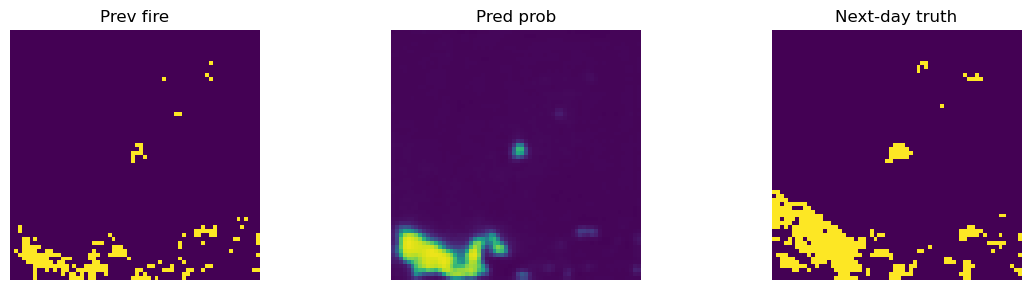

In [6]:
import matplotlib.pyplot as plt
@torch.no_grad()
def show_one(ds, i=0):
    b = ds[i]
    X_raw0 = b["X_raw"].unsqueeze(0).to(device)
    y = b["y"][0].numpy()
    X = build_input_for_net(X_raw0)
    prob = torch.sigmoid(model(X))[0,0].cpu().numpy()
    fig,axs = plt.subplots(1,3, figsize=(12,3))
    axs[0].imshow(b["X_raw"][0], vmin=0, vmax=1); axs[0].set_title("Prev fire")
    axs[1].imshow(prob, vmin=0, vmax=1);          axs[1].set_title("Pred prob")
    axs[2].imshow(y, vmin=0, vmax=1);             axs[2].set_title("Next-day truth")
    for a in axs: a.axis('off')
    plt.tight_layout(); plt.show()

show_one(test_ds, i=0)